#### <center><strong style="color:#363062">Rainfall Forecast</strong></center>

##### <strong style="color:#ff9717"><em>Tiền xử lý dữ liệu</em></strong>

In [797]:
# Import the libraries

import pandas as pd
import matplotlib.pyplot as plt 

In [798]:
# Read data

date_col = 'Date'
rainfall_col = 'RF_LeThuy'

df = pd.read_csv('data.csv')
df = pd.DataFrame({ 'Date': df[date_col], 'Rainfall': df[rainfall_col] })

In [799]:
# Set the correct data type

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
df['Rainfall'] = pd.to_numeric(df['Rainfall'], errors='coerce')

In [800]:
# Display missing value

for i in range(len(df.columns)):
  missing_data = df[df.columns[i]].isna().sum()
  print(f'> Columns {i}[{df.columns[i]}] missing entries: {missing_data}')

> Columns 0[Date] missing entries: 0
> Columns 1[Rainfall] missing entries: 3


In [801]:
# Fill missing value with mode

mode_value = df['Rainfall'].mode()[0]
df['Rainfall'].fillna(mode_value, inplace=True)

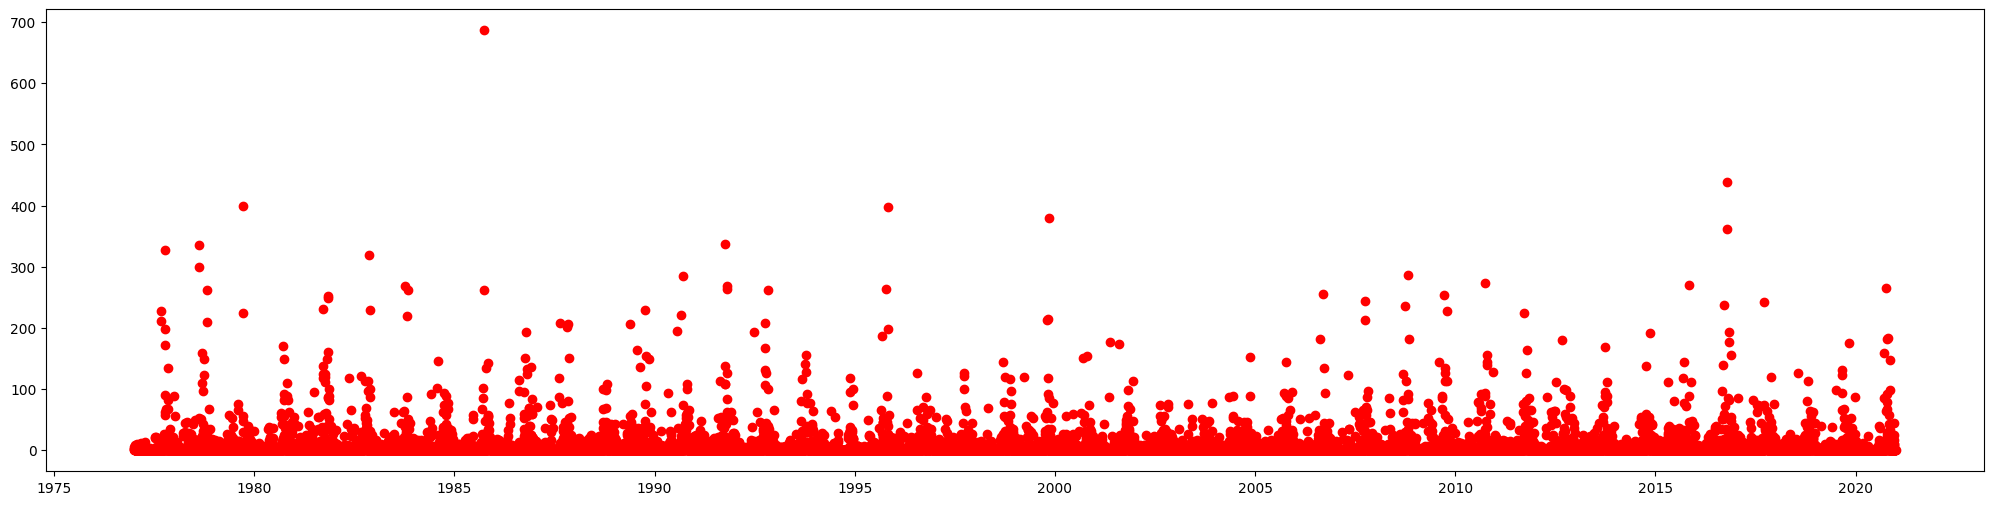

In [802]:
index_day = list(range(len(df['Date'])))

plt.figure(figsize=(25, 6))
plt.scatter(df['Date'], df['Rainfall'], c='red', marker='o', label='Lượng mưa')
plt.show()

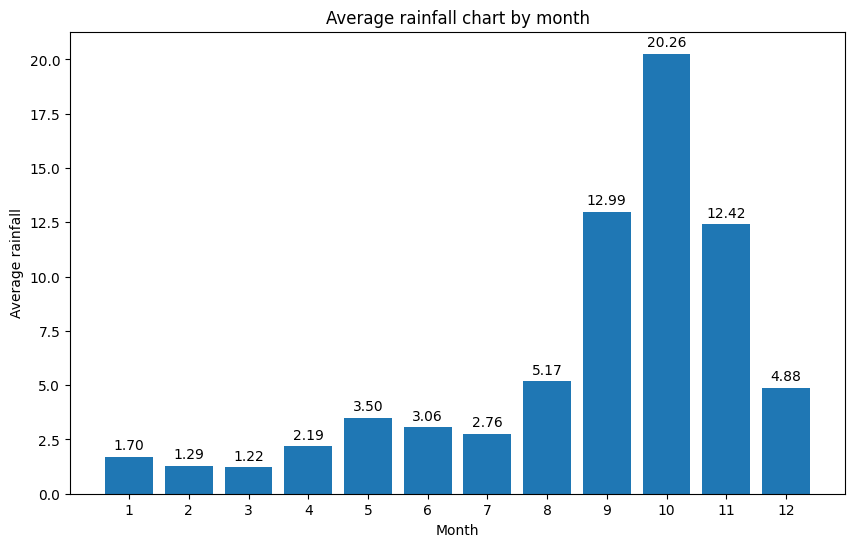

In [803]:
df['Month'] = df['Date'].dt.month
monthly_avg = df.groupby('Month')['Rainfall'].mean()

# Show chart
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_avg.index, monthly_avg.values)
plt.xlabel('Month')
plt.ylabel('Average rainfall')
plt.title('Average rainfall chart by month')

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), 
    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.xticks(range(1, 13))
plt.show()

In [804]:
# Split data from month

data = df[df['Month'].between(8, 12)].copy()
data = data[data['Rainfall'] <= 250]

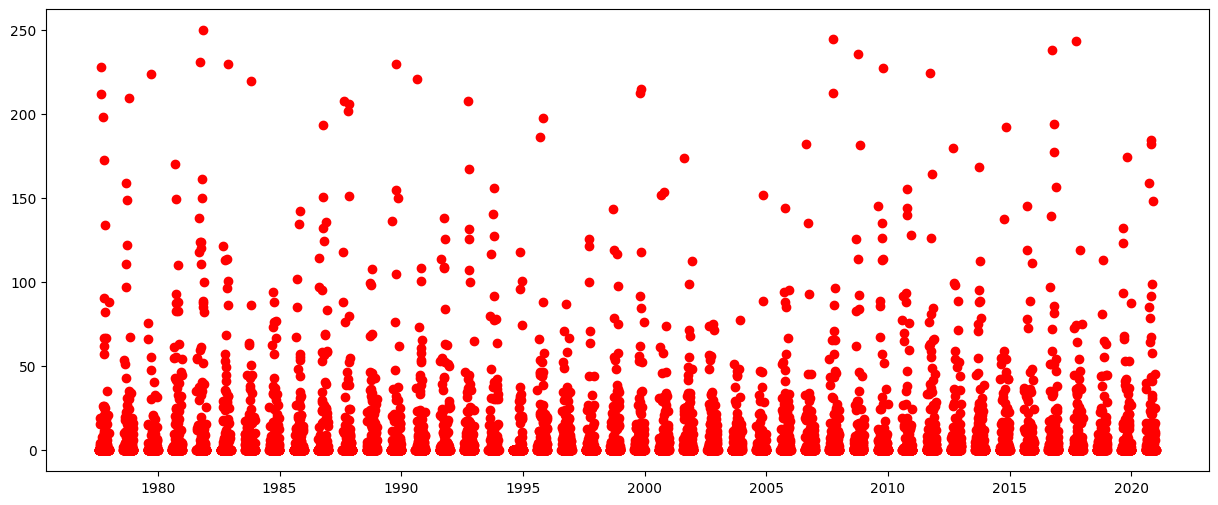

In [805]:
index_day = list(range(len(data['Date'])))

# Show chart
plt.figure(figsize=(15, 6))
plt.scatter(data['Date'], data['Rainfall'], c='red', marker='o')
plt.show()

In [806]:
data.drop(columns=['Date', 'Month'], axis=1, inplace=True)

In [807]:
# Categorize the data into 4 levels
import numpy as np

def CategorizeRainFall(x):
  if (x < 16): return 0
  elif ( x < 51): return 1
  elif ( x <= 100): return 2
  else: return 3

data['Rainfall'] = pd.to_numeric(data['Rainfall'], errors='coerce')
data.dropna(subset=['Rainfall'], inplace=True)

In [808]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix
import seaborn as sns

def ScoreSVM(X, y):
  SVM = SVC(kernel='sigmoid' ,decision_function_shape='ovr')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
  SVM.fit(X_train, y_train)
  y_pred = SVM.predict(X_test)
  print(classification_report(y_test, y_pred, zero_division=1))
  precision, recall, f1_core ,support = precision_recall_fscore_support(y_test, y_pred, average='macro')
  accuracy = accuracy_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)

  # Display confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()
  return precision, recall, f1_core ,support, accuracy

In [809]:
def process_data(data, days):
    dt = data.copy()
    for i in range(1, days + 1):
        dt[f'{i} Days Before'] = dt['Rainfall'].shift(-i)
    dt.dropna(inplace=True)
    X = dt.drop(['Rainfall', '0 Days Before'], axis=1)
    y = dt['Rainfall']
    return X, y

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1148
           1       0.64      0.72      0.68       143
           2       0.00      0.00      1.00        33
           3       0.00      0.00      1.00        17

    accuracy                           0.89      1341
   macro avg       0.40      0.42      0.91      1341
weighted avg       0.89      0.89      0.93      1341



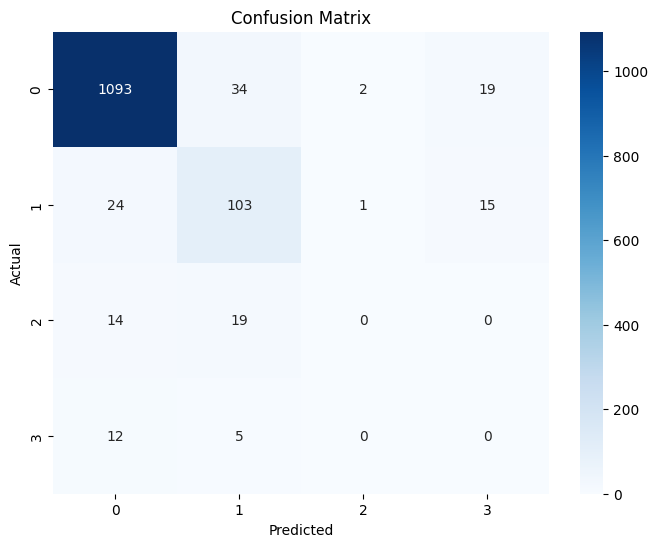

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1137
           1       0.50      0.79      0.61       144
           2       0.00      0.00      1.00        40
           3       0.00      0.00      1.00        20

    accuracy                           0.89      1341
   macro avg       0.37      0.43      0.89      1341
weighted avg       0.88      0.89      0.92      1341



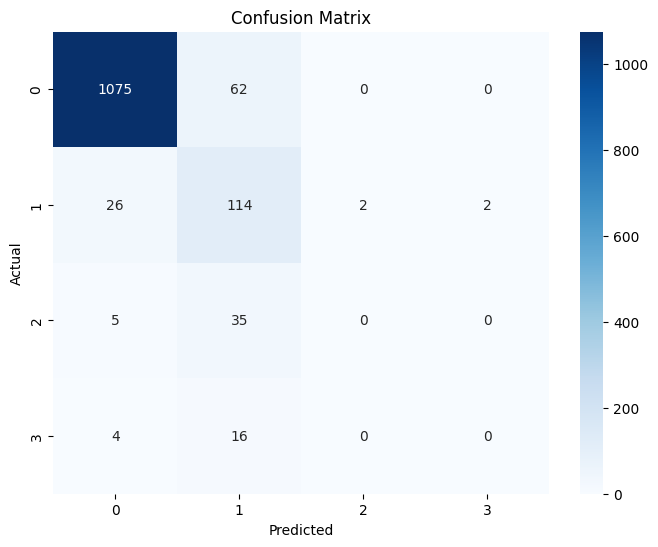

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1145
           1       0.46      0.86      0.60       134
           2       0.00      0.00      1.00        40
           3       1.00      0.00      0.00        22

    accuracy                           0.89      1341
   macro avg       0.61      0.45      0.64      1341
weighted avg       0.91      0.89      0.91      1341



c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


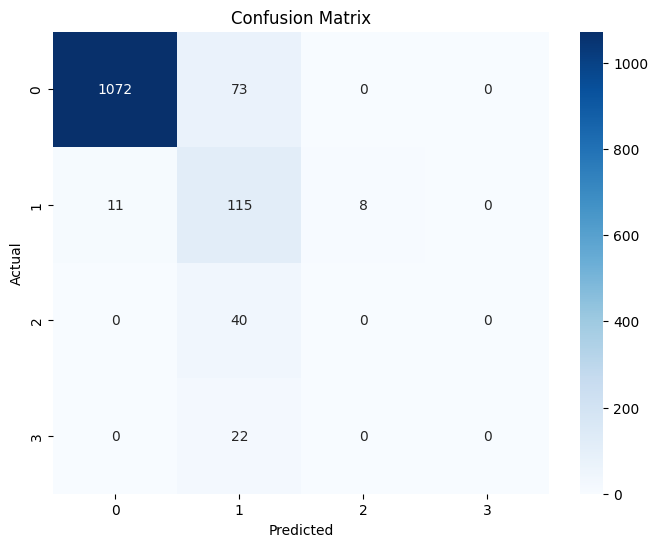

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1136
           1       0.36      0.56      0.44       140
           2       0.00      0.00      1.00        41
           3       0.00      0.00      1.00        23

    accuracy                           0.85      1340
   macro avg       0.33      0.37      0.85      1340
weighted avg       0.84      0.85      0.89      1340



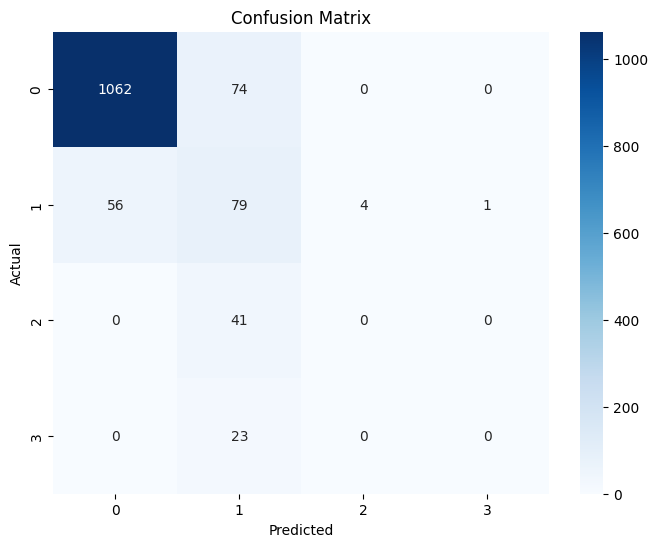

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1126
           1       0.41      0.68      0.51       147
           2       0.00      0.00      1.00        45
           3       0.00      0.00      1.00        22

    accuracy                           0.86      1340
   macro avg       0.35      0.40      0.87      1340
weighted avg       0.87      0.86      0.91      1340



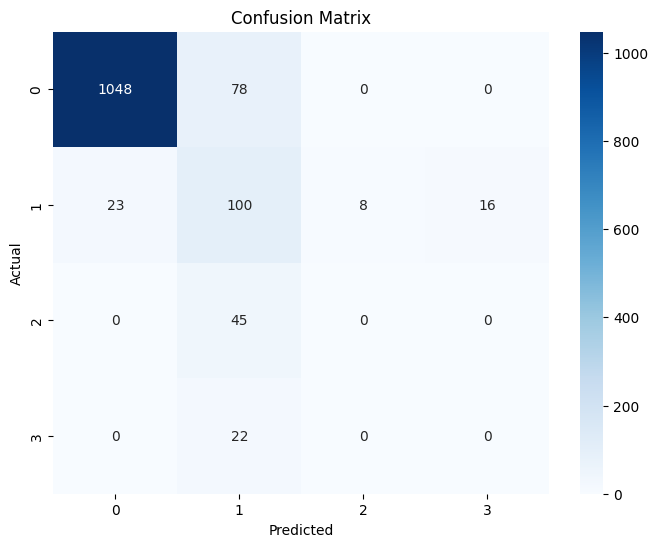

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1128
           1       0.39      0.64      0.48       143
           2       0.17      0.03      0.04        40
           3       0.00      0.00      1.00        29

    accuracy                           0.85      1340
   macro avg       0.38      0.40      0.62      1340
weighted avg       0.86      0.85      0.87      1340



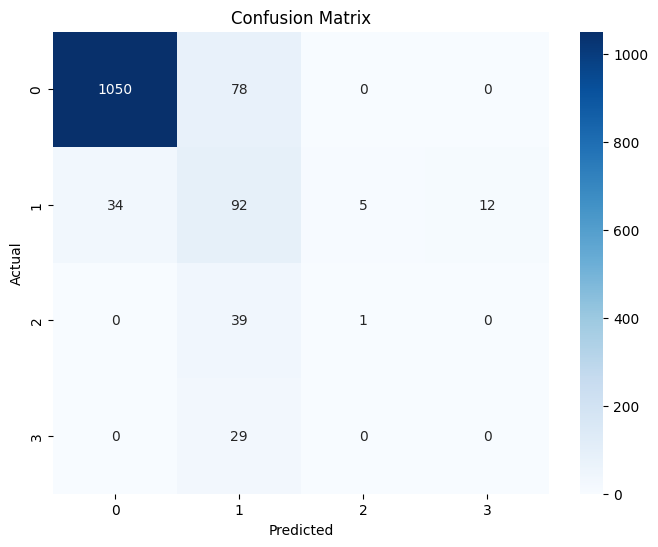

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1128
           1       0.32      0.46      0.38       143
           2       0.75      0.08      0.14        39
           3       0.00      0.00      1.00        30

    accuracy                           0.84      1340
   macro avg       0.50      0.37      0.61      1340
weighted avg       0.85      0.84      0.86      1340



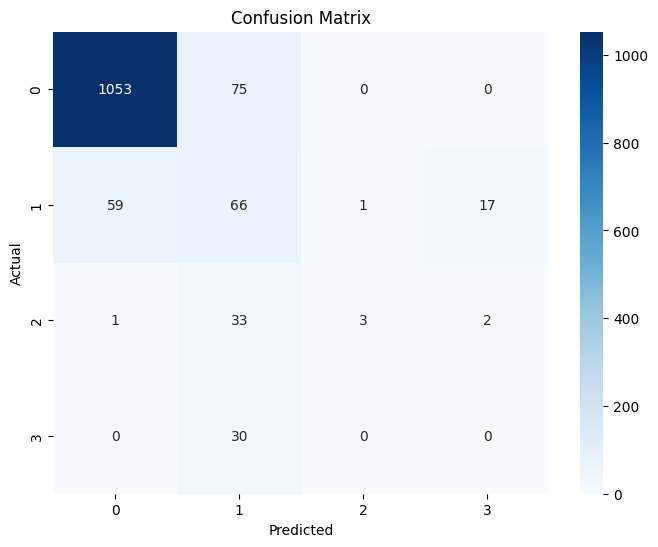

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1128
           1       0.34      0.46      0.39       140
           2       0.90      0.19      0.32        47
           3       0.00      0.00      1.00        25

    accuracy                           0.84      1340
   macro avg       0.55      0.40      0.66      1340
weighted avg       0.86      0.84      0.86      1340



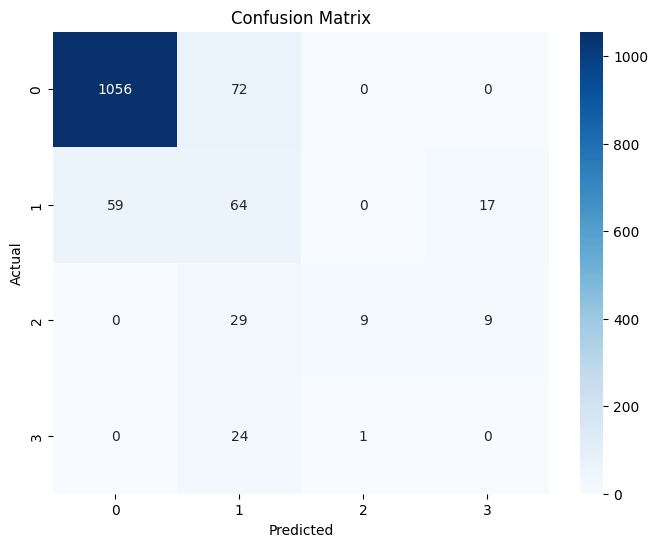

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1126
           1       0.37      0.51      0.43       136
           2       0.64      0.14      0.23        49
           3       0.00      0.00      1.00        28

    accuracy                           0.85      1339
   macro avg       0.49      0.40      0.65      1339
weighted avg       0.86      0.85      0.87      1339



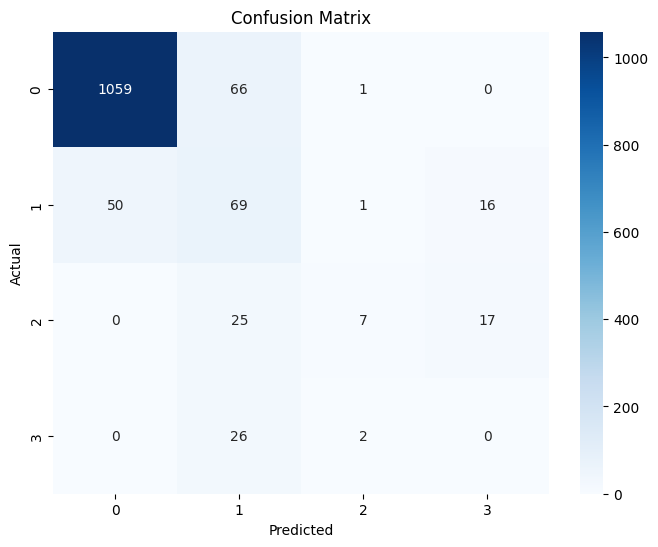

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1137
           1       0.37      0.48      0.42       135
           2       0.65      0.26      0.37        42
           3       0.00      0.00      1.00        25

    accuracy                           0.85      1339
   macro avg       0.49      0.42      0.68      1339
weighted avg       0.87      0.85      0.87      1339



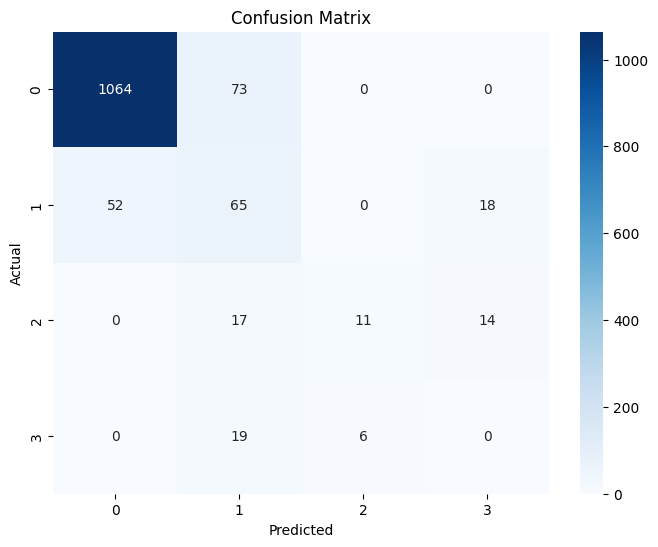

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1140
           1       0.33      0.41      0.37       135
           2       0.58      0.17      0.26        42
           3       0.00      0.00      1.00        22

    accuracy                           0.84      1339
   macro avg       0.47      0.38      0.64      1339
weighted avg       0.86      0.84      0.86      1339



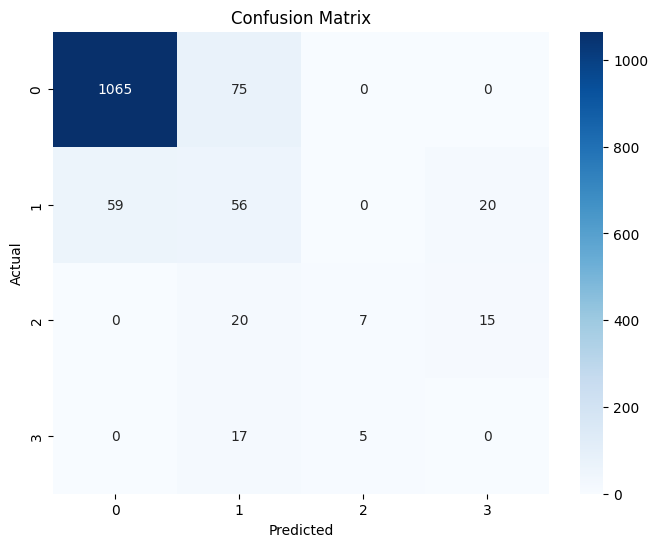

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1139
           1       0.44      0.53      0.48       138
           2       0.62      0.36      0.45        42
           3       0.00      0.00      1.00        20

    accuracy                           0.87      1339
   macro avg       0.50      0.46      0.72      1339
weighted avg       0.88      0.87      0.88      1339



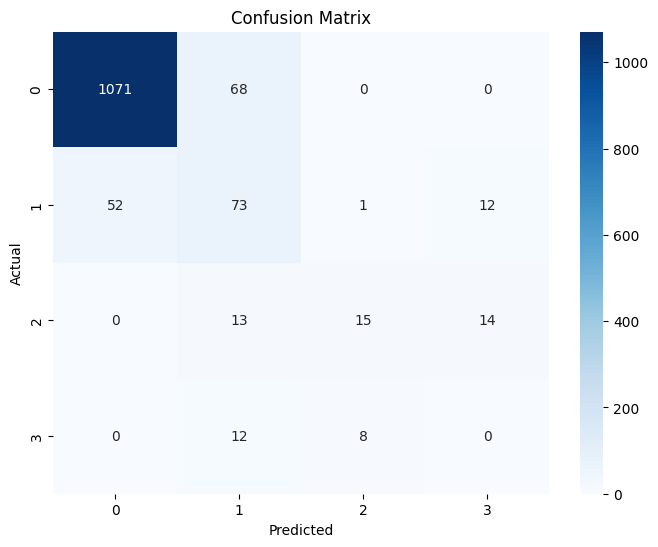

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1138
           1       0.45      0.54      0.49       146
           2       0.35      0.29      0.32        31
           3       0.00      0.00      1.00        24

    accuracy                           0.86      1339
   macro avg       0.44      0.44      0.69      1339
weighted avg       0.86      0.86      0.88      1339



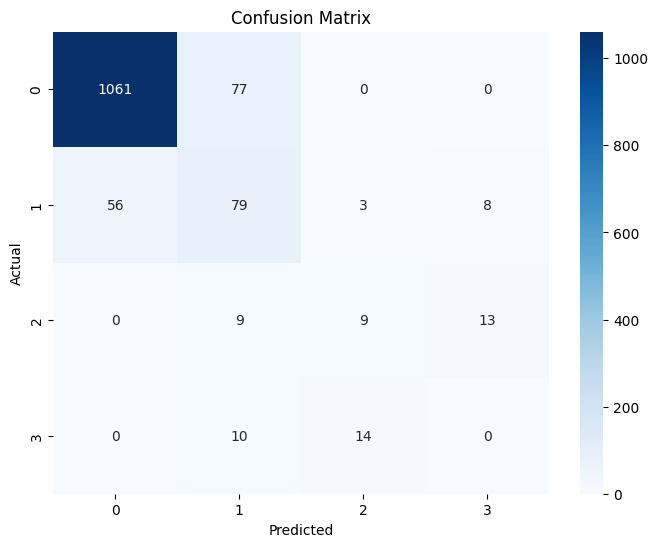

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1135
           1       0.48      0.58      0.52       137
           2       0.48      0.37      0.42        43
           3       0.00      0.00      1.00        23

    accuracy                           0.87      1338
   macro avg       0.48      0.47      0.72      1338
weighted avg       0.87      0.87      0.89      1338



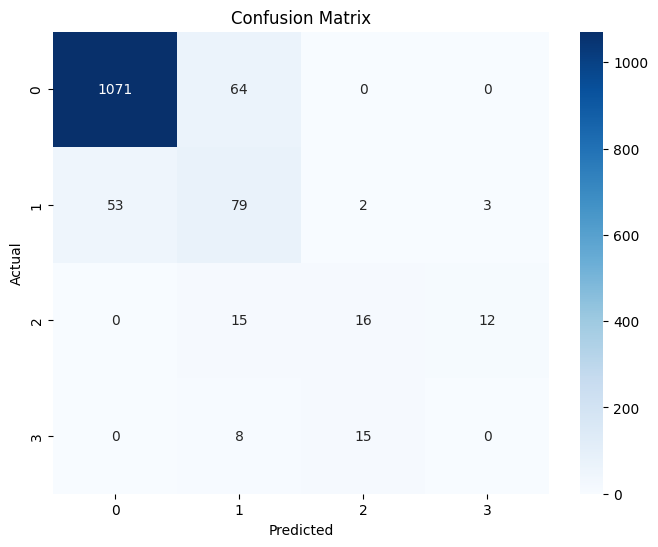

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1138
           1       0.52      0.55      0.53       141
           2       0.40      0.35      0.37        40
           3       0.00      0.00      1.00        19

    accuracy                           0.88      1338
   macro avg       0.47      0.46      0.71      1338
weighted avg       0.88      0.88      0.89      1338



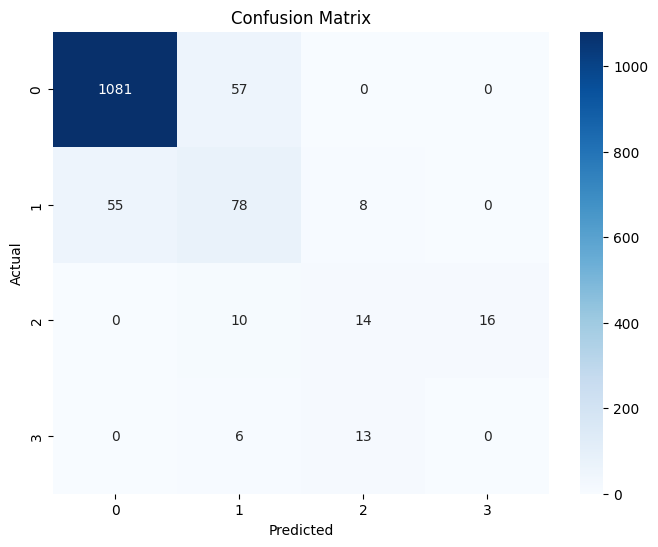

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1134
           1       0.44      0.50      0.47       136
           2       0.52      0.50      0.51        44
           3       0.00      0.00      1.00        24

    accuracy                           0.86      1338
   macro avg       0.48      0.48      0.73      1338
weighted avg       0.86      0.86      0.88      1338



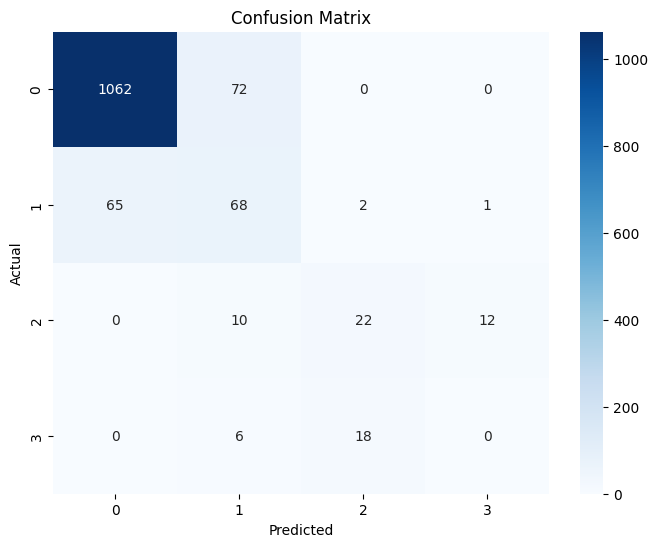

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1126
           1       0.53      0.48      0.51       150
           2       0.47      0.51      0.49        41
           3       0.08      0.05      0.06        21

    accuracy                           0.87      1338
   macro avg       0.50      0.50      0.50      1338
weighted avg       0.86      0.87      0.87      1338



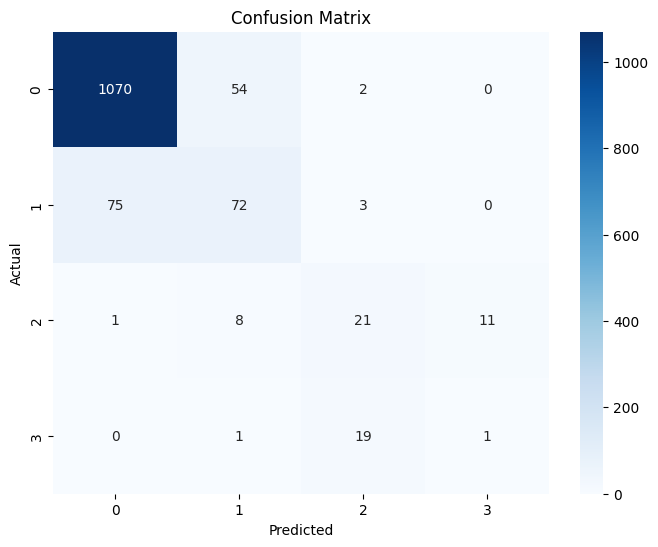

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1130
           1       0.56      0.50      0.53       147
           2       0.38      0.46      0.42        39
           3       0.08      0.05      0.06        22

    accuracy                           0.87      1338
   macro avg       0.49      0.49      0.49      1338
weighted avg       0.87      0.87      0.87      1338



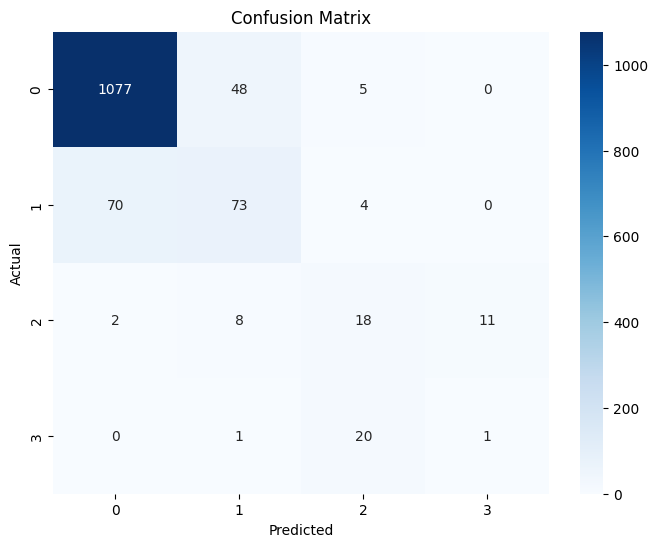

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1133
           1       0.48      0.42      0.45       139
           2       0.44      0.45      0.45        42
           3       0.11      0.09      0.10        23

    accuracy                           0.87      1337
   macro avg       0.49      0.48      0.48      1337
weighted avg       0.86      0.87      0.86      1337



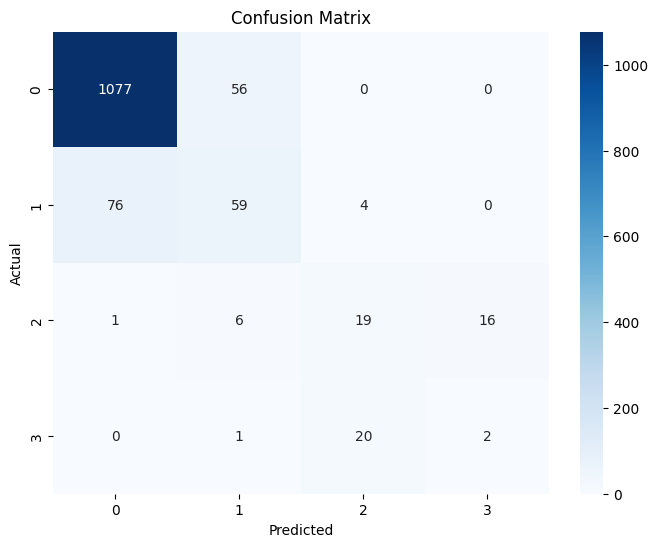

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1132
           1       0.51      0.55      0.53       145
           2       0.40      0.39      0.39        36
           3       0.17      0.08      0.11        24

    accuracy                           0.87      1337
   macro avg       0.51      0.49      0.50      1337
weighted avg       0.87      0.87      0.87      1337



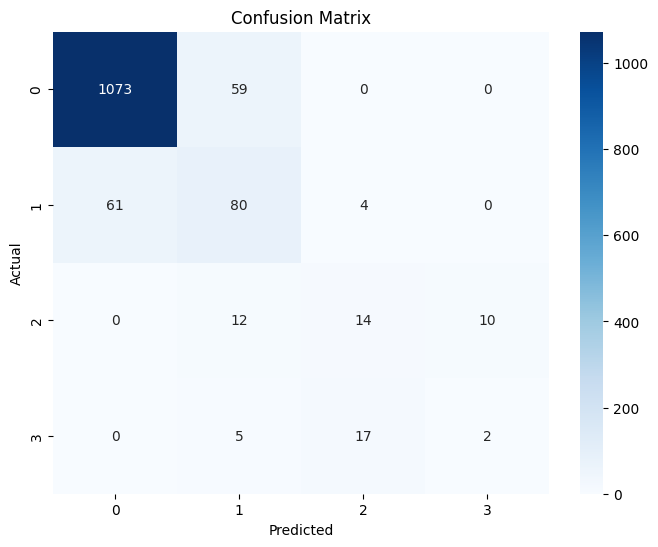

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1138
           1       0.50      0.57      0.53       137
           2       0.52      0.56      0.54        39
           3       0.21      0.13      0.16        23

    accuracy                           0.88      1337
   macro avg       0.55      0.55      0.55      1337
weighted avg       0.88      0.88      0.88      1337



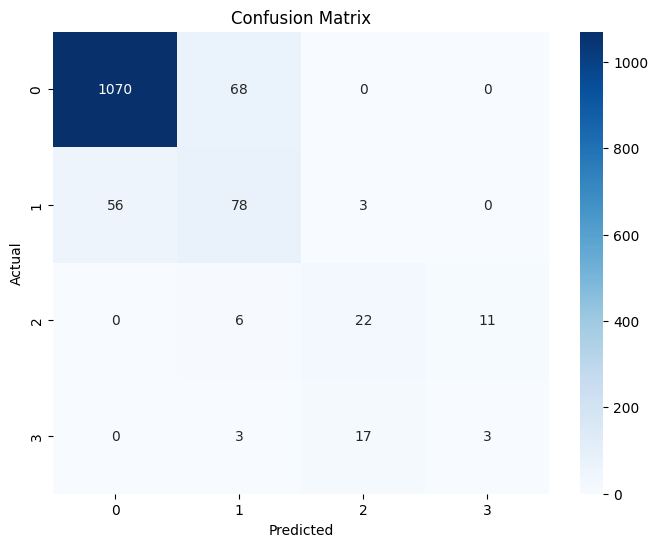

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1140
           1       0.50      0.59      0.54       136
           2       0.49      0.47      0.48        38
           3       0.21      0.13      0.16        23

    accuracy                           0.88      1337
   macro avg       0.54      0.53      0.53      1337
weighted avg       0.88      0.88      0.88      1337



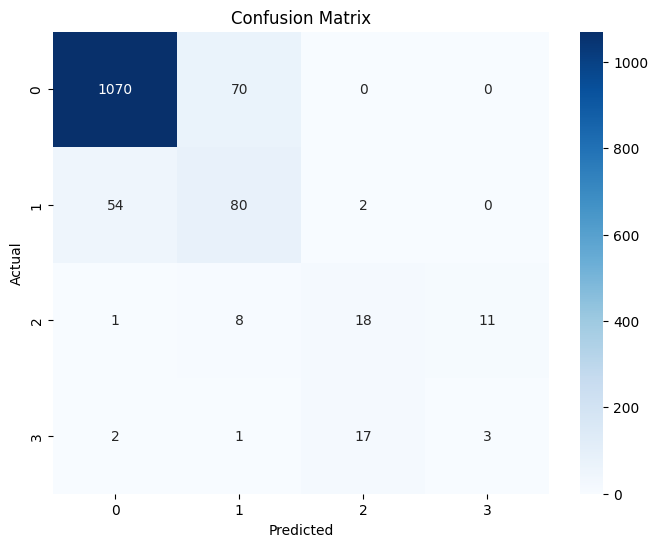

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1141
           1       0.50      0.54      0.52       135
           2       0.54      0.57      0.55        37
           3       0.39      0.29      0.33        24

    accuracy                           0.88      1337
   macro avg       0.59      0.59      0.59      1337
weighted avg       0.88      0.88      0.88      1337



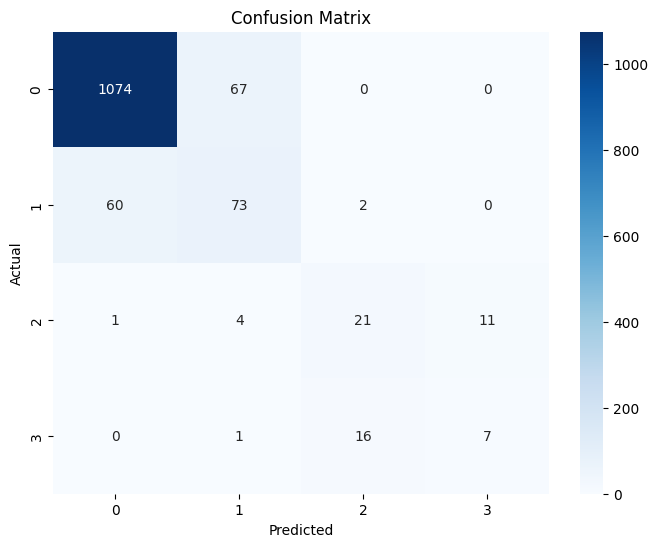

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1127
           1       0.51      0.54      0.52       143
           2       0.31      0.20      0.24        41
           3       0.28      0.28      0.28        25

    accuracy                           0.87      1336
   macro avg       0.51      0.49      0.50      1336
weighted avg       0.87      0.87      0.87      1336



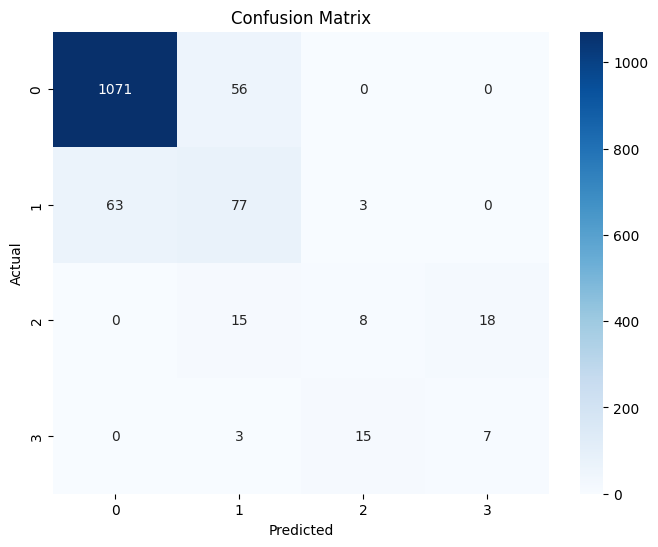

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1104
           1       0.57      0.48      0.52       162
           2       0.52      0.35      0.41        49
           3       0.20      0.24      0.22        21

    accuracy                           0.87      1336
   macro avg       0.55      0.51      0.53      1336
weighted avg       0.86      0.87      0.86      1336



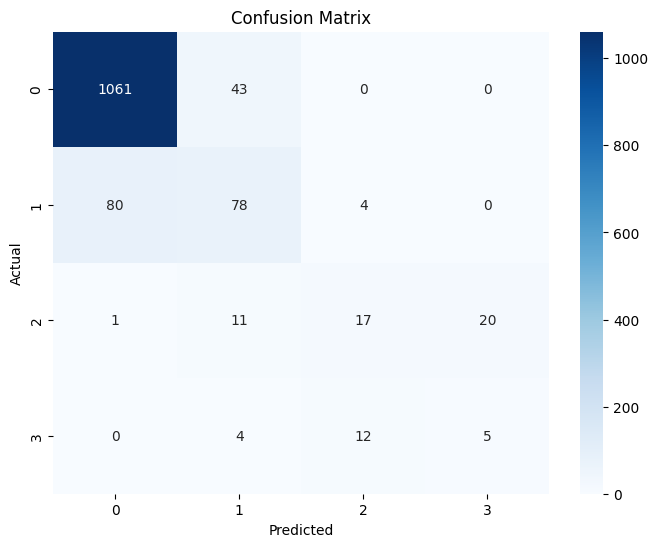

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1111
           1       0.54      0.44      0.48       154
           2       0.38      0.29      0.33        45
           3       0.30      0.23      0.26        26

    accuracy                           0.87      1336
   macro avg       0.54      0.48      0.51      1336
weighted avg       0.85      0.87      0.86      1336



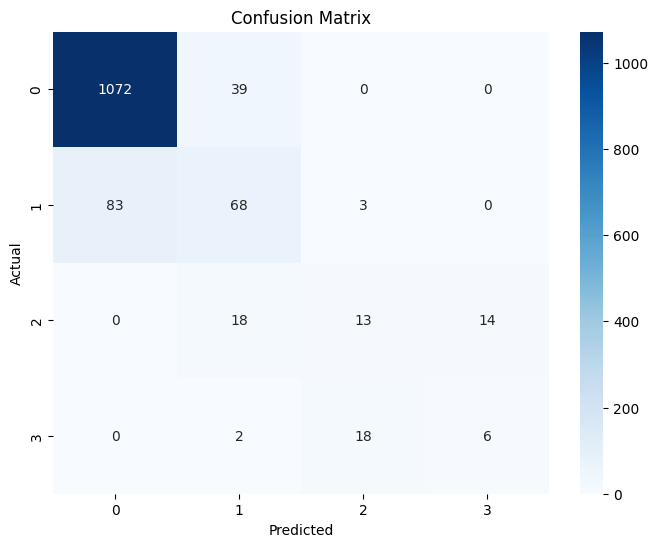

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1133
           1       0.53      0.45      0.49       141
           2       0.47      0.40      0.43        40
           3       0.32      0.27      0.29        22

    accuracy                           0.88      1336
   macro avg       0.56      0.52      0.54      1336
weighted avg       0.87      0.88      0.87      1336



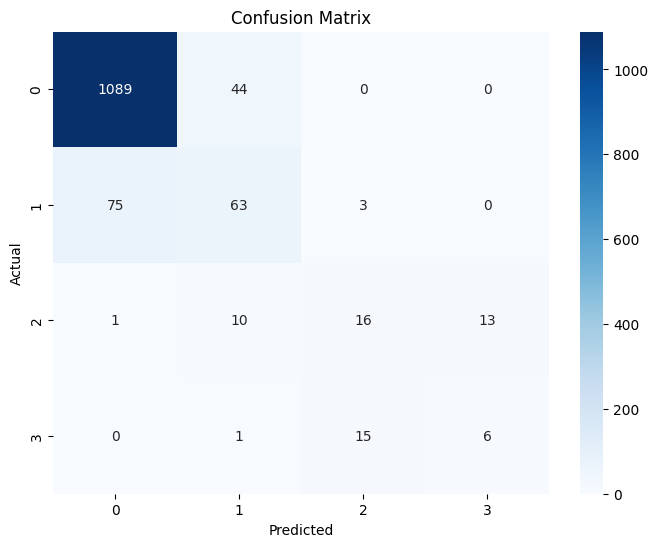

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1122
           1       0.54      0.48      0.51       151
           2       0.52      0.43      0.47        37
           3       0.50      0.35      0.41        26

    accuracy                           0.88      1336
   macro avg       0.62      0.55      0.58      1336
weighted avg       0.87      0.88      0.87      1336



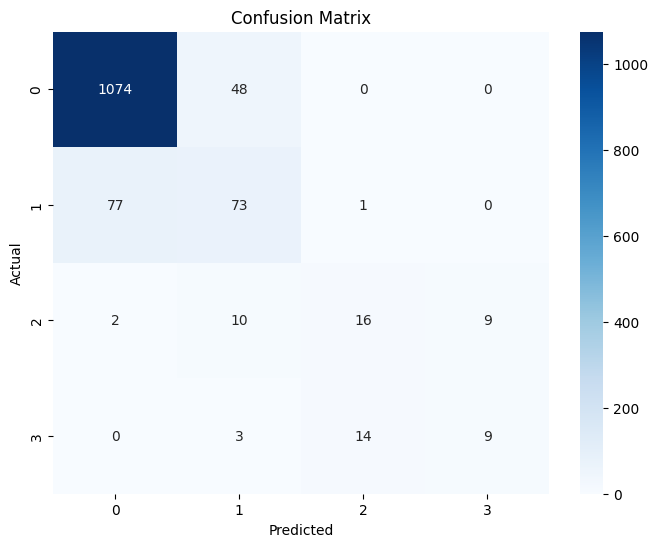

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1110
           1       0.57      0.55      0.56       157
           2       0.56      0.38      0.46        47
           3       0.40      0.38      0.39        21

    accuracy                           0.88      1335
   macro avg       0.62      0.57      0.59      1335
weighted avg       0.87      0.88      0.88      1335



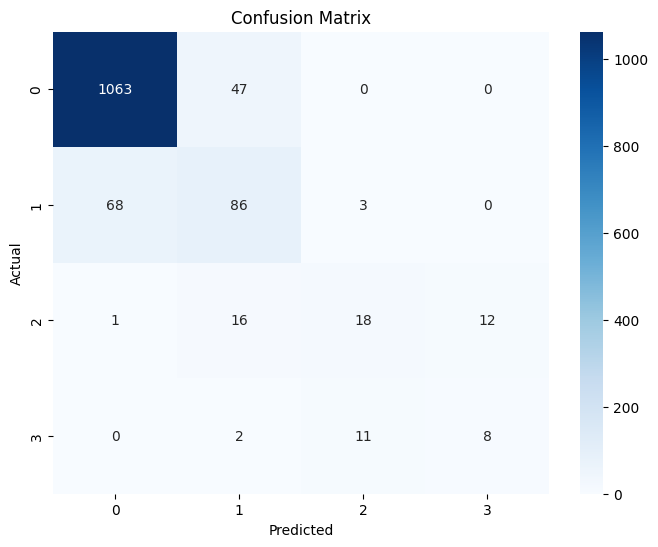

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1127
           1       0.50      0.48      0.49       149
           2       0.45      0.32      0.37        41
           3       0.30      0.33      0.32        18

    accuracy                           0.87      1335
   macro avg       0.55      0.52      0.53      1335
weighted avg       0.87      0.87      0.87      1335



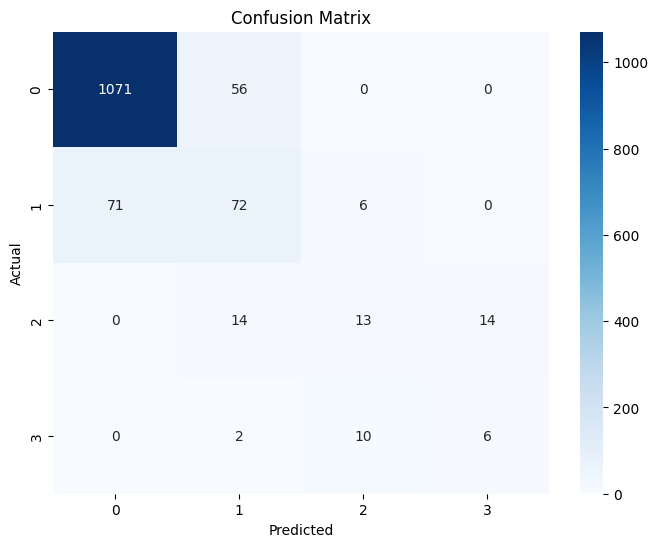

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1109
           1       0.56      0.47      0.51       159
           2       0.49      0.49      0.49        45
           3       0.29      0.23      0.26        22

    accuracy                           0.87      1335
   macro avg       0.57      0.53      0.55      1335
weighted avg       0.86      0.87      0.87      1335



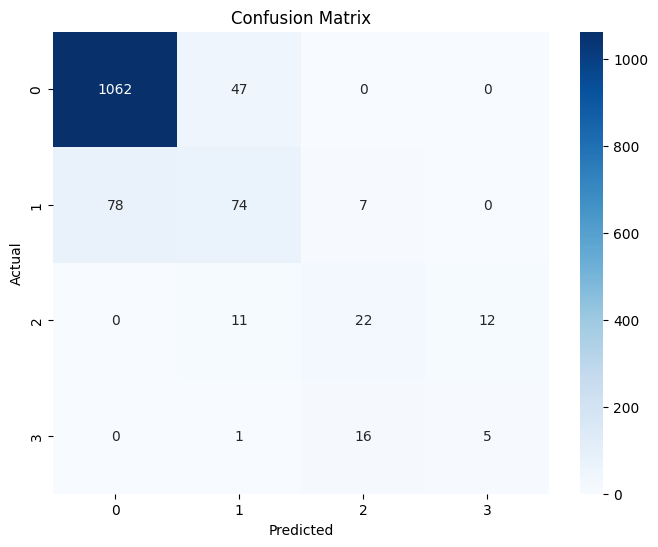

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1117
           1       0.54      0.57      0.55       147
           2       0.54      0.47      0.50        45
           3       0.53      0.38      0.44        26

    accuracy                           0.88      1335
   macro avg       0.64      0.59      0.61      1335
weighted avg       0.88      0.88      0.88      1335



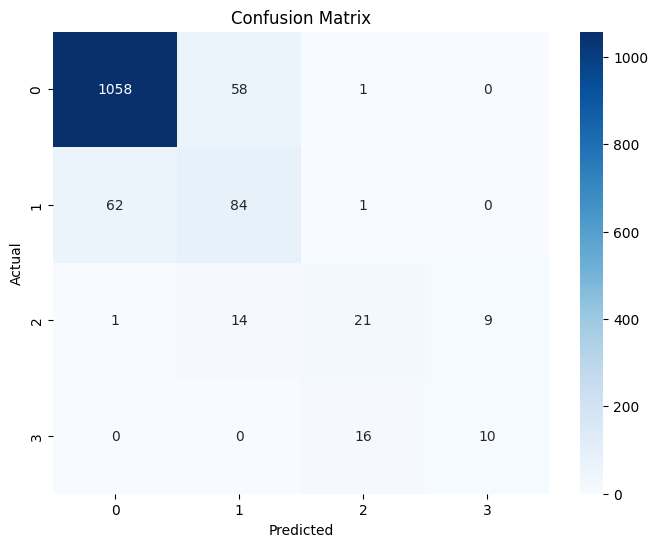

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1121
           1       0.50      0.44      0.47       140
           2       0.44      0.39      0.41        46
           3       0.45      0.32      0.38        28

    accuracy                           0.87      1335
   macro avg       0.58      0.53      0.55      1335
weighted avg       0.86      0.87      0.87      1335



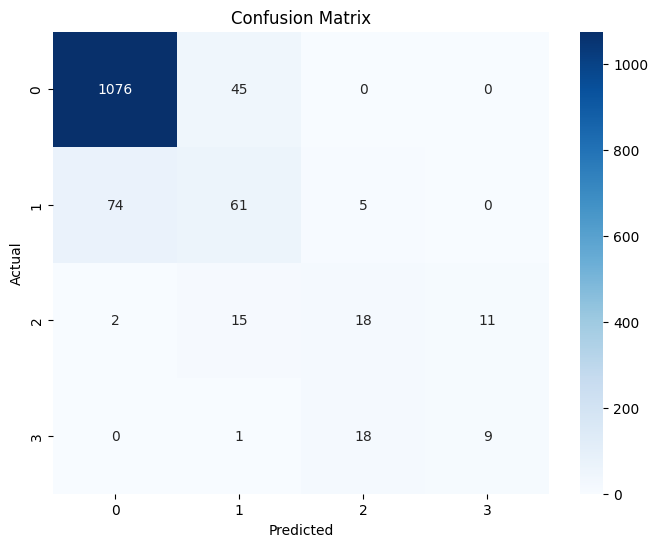

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1122
           1       0.49      0.47      0.48       149
           2       0.58      0.50      0.54        44
           3       0.46      0.32      0.37        19

    accuracy                           0.87      1334
   macro avg       0.62      0.56      0.58      1334
weighted avg       0.87      0.87      0.87      1334



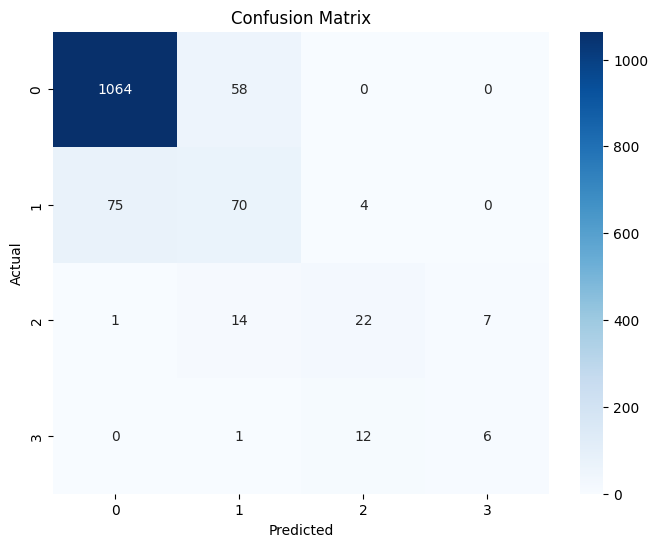

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1121
           1       0.46      0.46      0.46       140
           2       0.56      0.55      0.55        44
           3       0.68      0.45      0.54        29

    accuracy                           0.87      1334
   macro avg       0.66      0.60      0.62      1334
weighted avg       0.87      0.87      0.87      1334



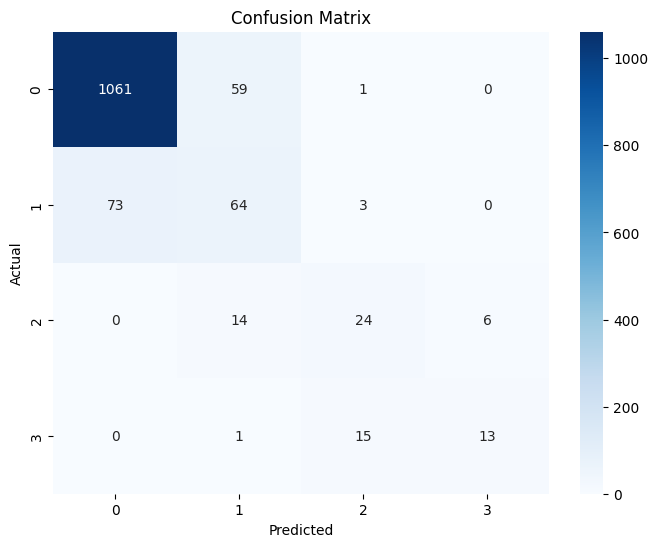

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1123
           1       0.45      0.49      0.47       135
           2       0.56      0.63      0.59        43
           3       0.79      0.45      0.58        33

    accuracy                           0.87      1334
   macro avg       0.68      0.63      0.64      1334
weighted avg       0.87      0.87      0.87      1334



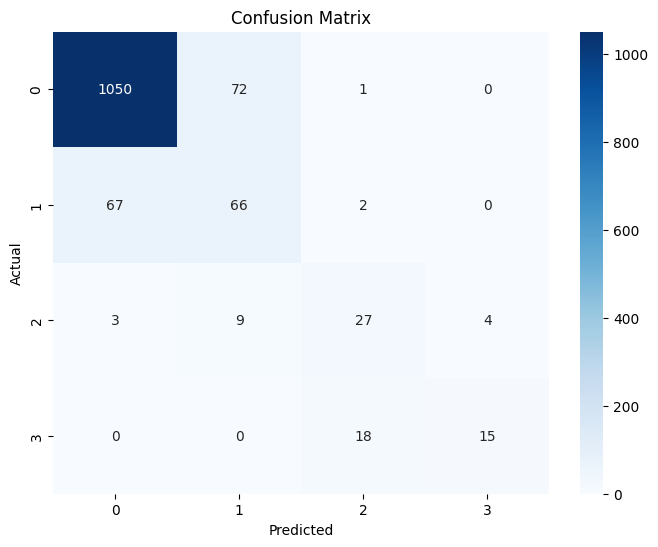

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1120
           1       0.55      0.50      0.52       142
           2       0.59      0.52      0.55        44
           3       0.61      0.50      0.55        28

    accuracy                           0.89      1334
   macro avg       0.67      0.62      0.64      1334
weighted avg       0.88      0.89      0.88      1334



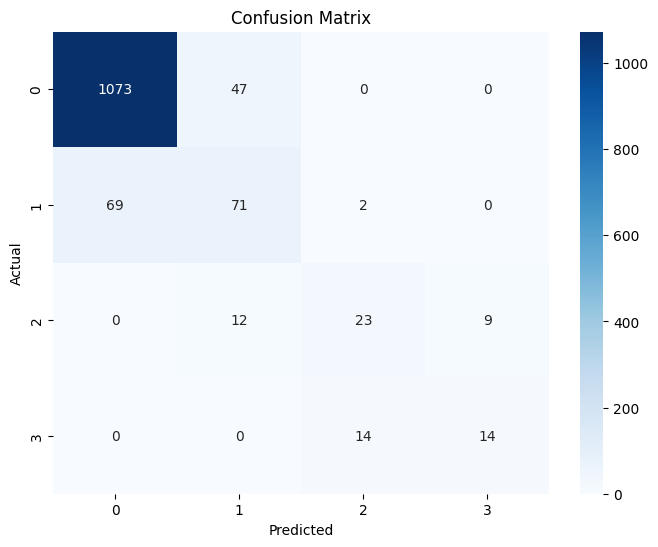

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1117
           1       0.57      0.50      0.53       145
           2       0.57      0.58      0.57        43
           3       0.70      0.48      0.57        29

    accuracy                           0.89      1334
   macro avg       0.69      0.63      0.66      1334
weighted avg       0.88      0.89      0.88      1334



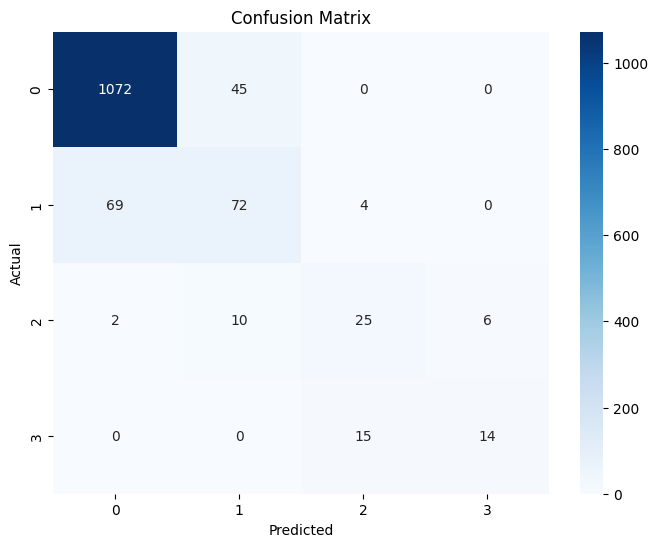

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1108
           1       0.51      0.49      0.50       144
           2       0.61      0.55      0.58        49
           3       0.77      0.53      0.63        32

    accuracy                           0.88      1333
   macro avg       0.71      0.63      0.66      1333
weighted avg       0.87      0.88      0.88      1333



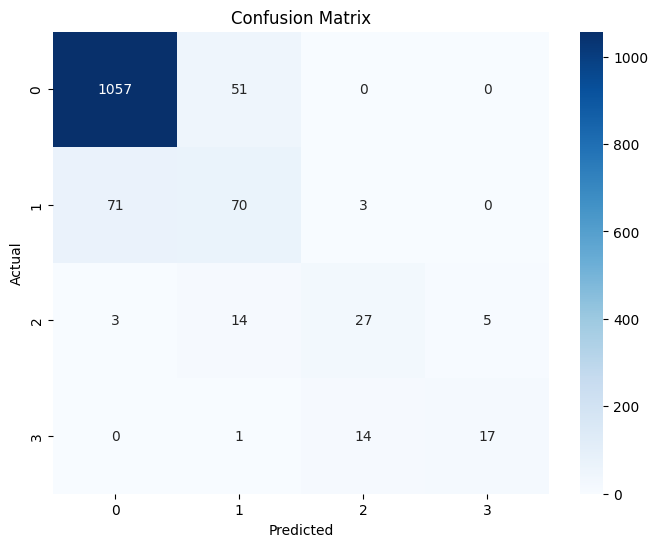

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1123
           1       0.57      0.58      0.58       148
           2       0.55      0.53      0.54        40
           3       0.64      0.32      0.42        22

    accuracy                           0.89      1333
   macro avg       0.68      0.59      0.62      1333
weighted avg       0.88      0.89      0.88      1333



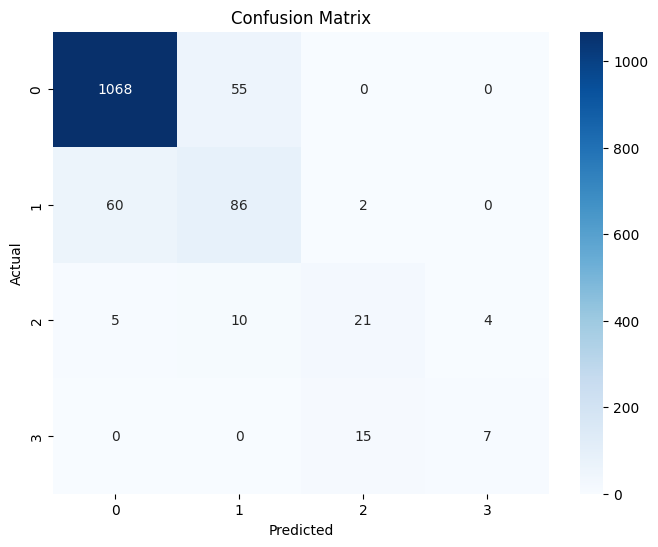

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1120
           1       0.56      0.51      0.53       144
           2       0.55      0.54      0.55        39
           3       0.74      0.47      0.57        30

    accuracy                           0.89      1333
   macro avg       0.70      0.62      0.65      1333
weighted avg       0.88      0.89      0.88      1333



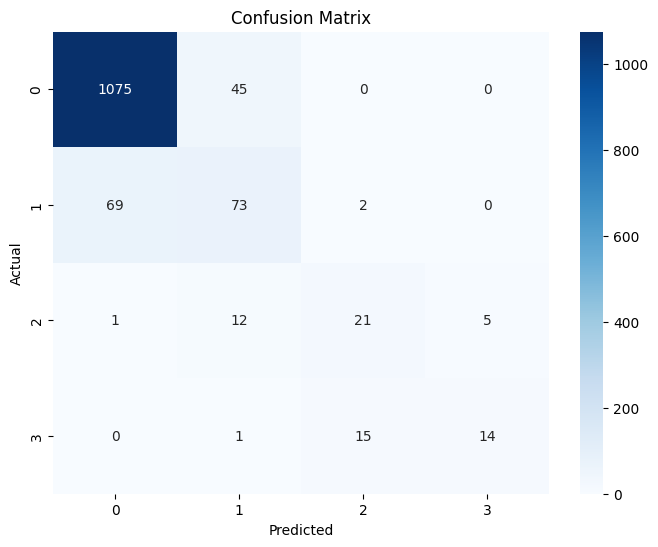

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1135
           1       0.55      0.52      0.53       136
           2       0.70      0.65      0.68        40
           3       0.75      0.55      0.63        22

    accuracy                           0.90      1333
   macro avg       0.74      0.67      0.70      1333
weighted avg       0.89      0.90      0.90      1333



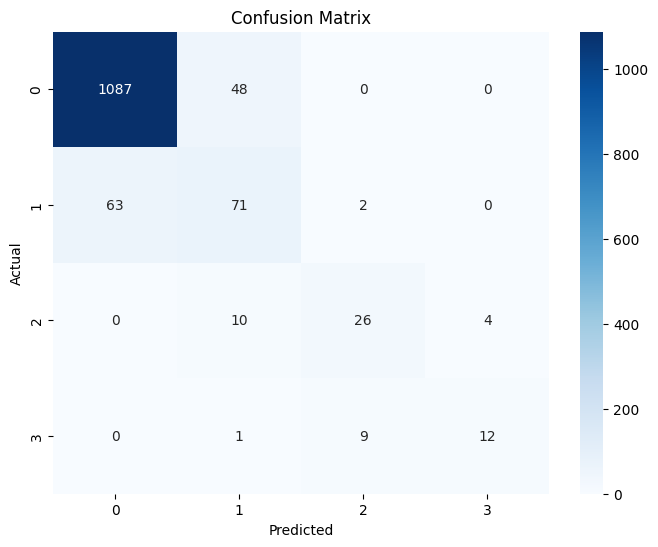

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1138
           1       0.54      0.49      0.51       139
           2       0.69      0.61      0.65        33
           3       0.78      0.61      0.68        23

    accuracy                           0.89      1333
   macro avg       0.74      0.67      0.70      1333
weighted avg       0.89      0.89      0.89      1333



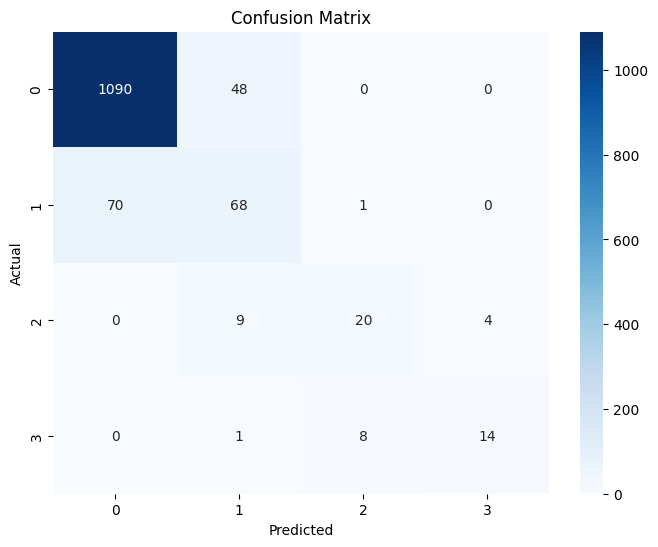

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1131
           1       0.50      0.53      0.52       134
           2       0.69      0.68      0.68        37
           3       0.91      0.67      0.77        30

    accuracy                           0.89      1332
   macro avg       0.76      0.70      0.73      1332
weighted avg       0.89      0.89      0.89      1332



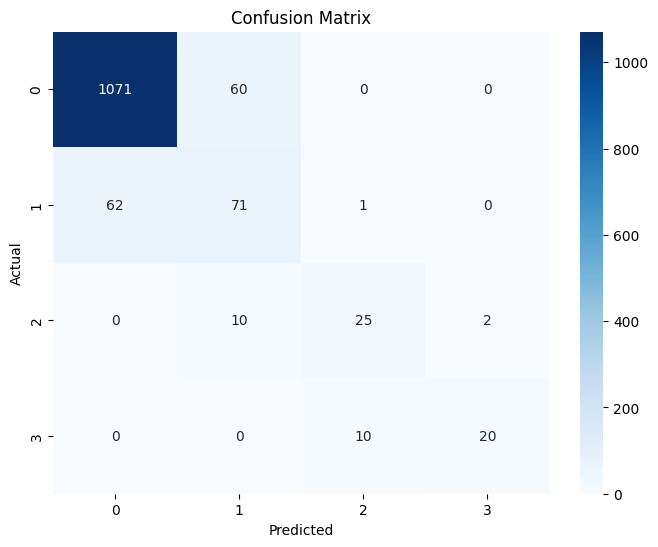

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1139
           1       0.56      0.53      0.54       131
           2       0.69      0.60      0.64        40
           3       0.78      0.64      0.70        22

    accuracy                           0.90      1332
   macro avg       0.74      0.68      0.71      1332
weighted avg       0.90      0.90      0.90      1332



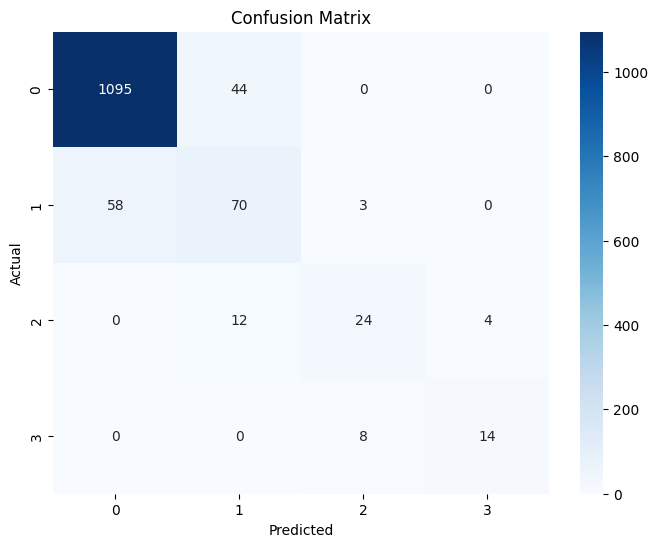

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1135
           1       0.59      0.54      0.56       140
           2       0.72      0.64      0.68        36
           3       0.82      0.67      0.74        21

    accuracy                           0.90      1332
   macro avg       0.77      0.70      0.73      1332
weighted avg       0.90      0.90      0.90      1332



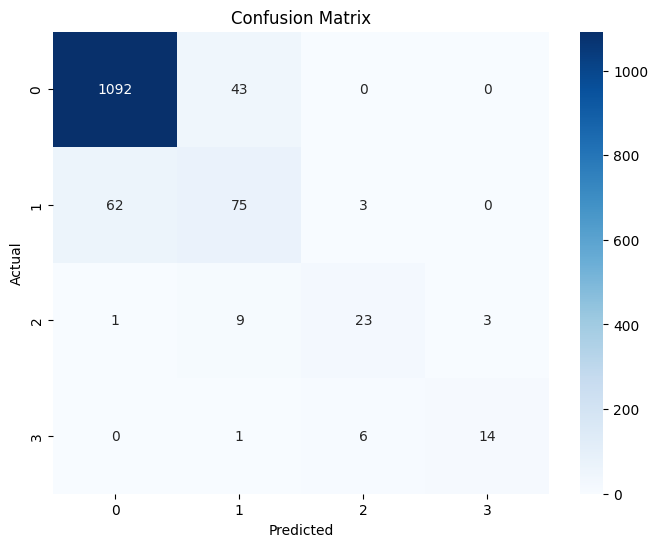

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1134
           1       0.55      0.49      0.52       136
           2       0.67      0.62      0.64        39
           3       0.74      0.61      0.67        23

    accuracy                           0.90      1332
   macro avg       0.72      0.67      0.69      1332
weighted avg       0.89      0.90      0.89      1332



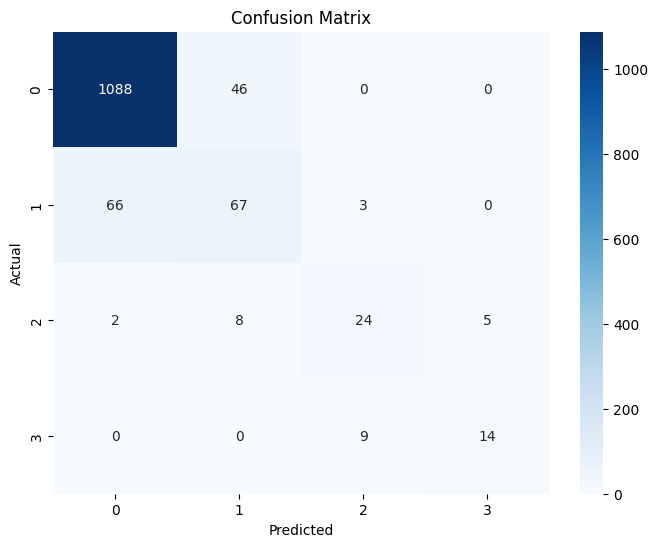

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1147
           1       0.49      0.49      0.49       124
           2       0.69      0.58      0.63        38
           3       0.83      0.65      0.73        23

    accuracy                           0.89      1332
   macro avg       0.74      0.67      0.70      1332
weighted avg       0.89      0.89      0.89      1332



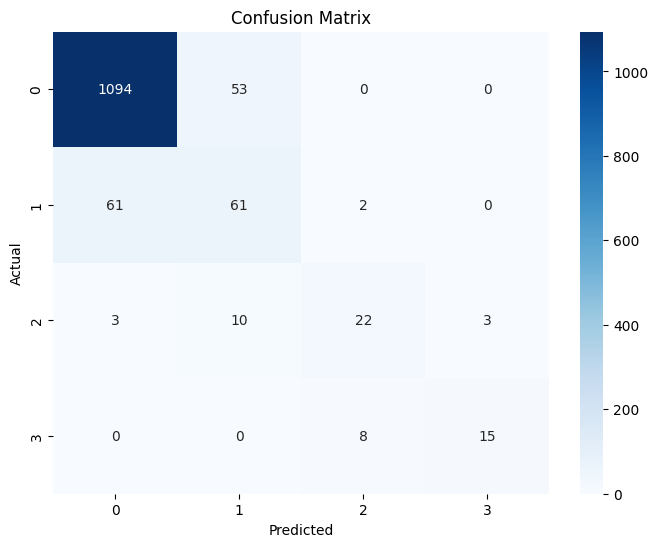

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1134
           1       0.54      0.52      0.53       132
           2       0.70      0.62      0.66        37
           3       0.80      0.71      0.75        28

    accuracy                           0.90      1331
   macro avg       0.75      0.70      0.72      1331
weighted avg       0.90      0.90      0.90      1331



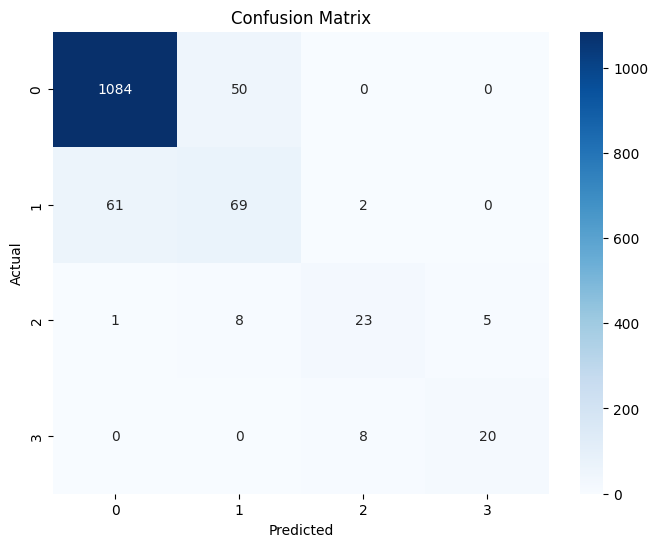

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1115
           1       0.63      0.50      0.56       151
           2       0.78      0.70      0.74        40
           3       0.79      0.76      0.78        25

    accuracy                           0.90      1331
   macro avg       0.78      0.73      0.76      1331
weighted avg       0.89      0.90      0.90      1331



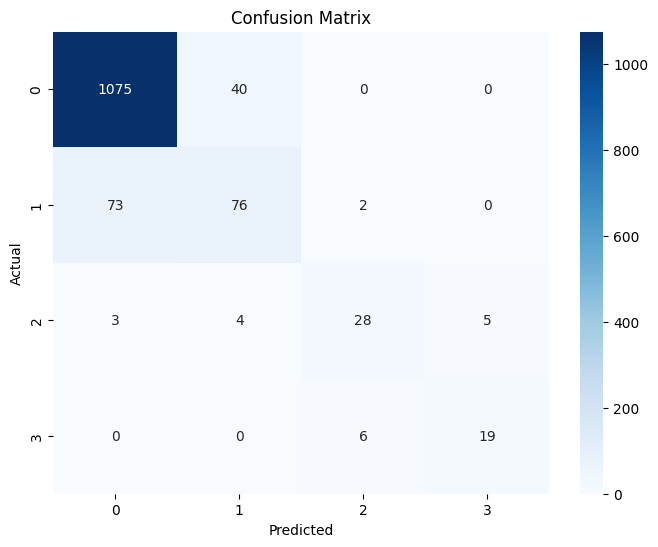

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1122
           1       0.53      0.47      0.50       150
           2       0.71      0.68      0.69        37
           3       0.78      0.64      0.70        22

    accuracy                           0.88      1331
   macro avg       0.74      0.68      0.71      1331
weighted avg       0.88      0.88      0.88      1331



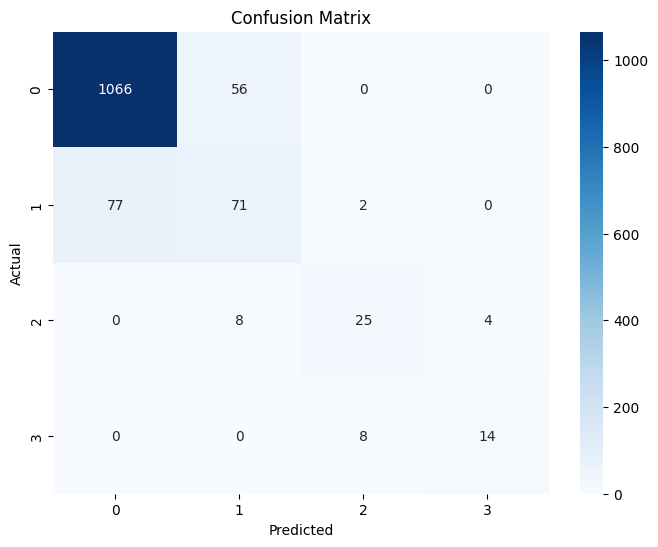

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1121
           1       0.57      0.54      0.55       151
           2       0.89      0.78      0.83        40
           3       0.94      0.79      0.86        19

    accuracy                           0.90      1331
   macro avg       0.83      0.76      0.79      1331
weighted avg       0.89      0.90      0.90      1331



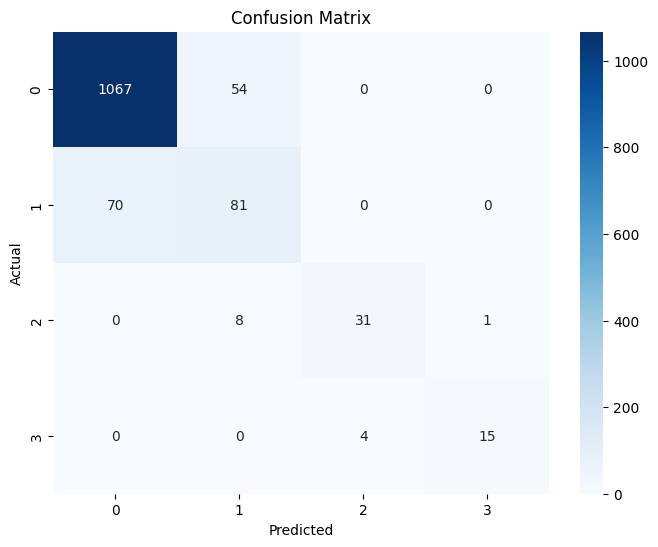

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1139
           1       0.49      0.50      0.49       124
           2       0.88      0.70      0.78        43
           3       0.92      0.88      0.90        25

    accuracy                           0.90      1331
   macro avg       0.81      0.76      0.78      1331
weighted avg       0.90      0.90      0.90      1331



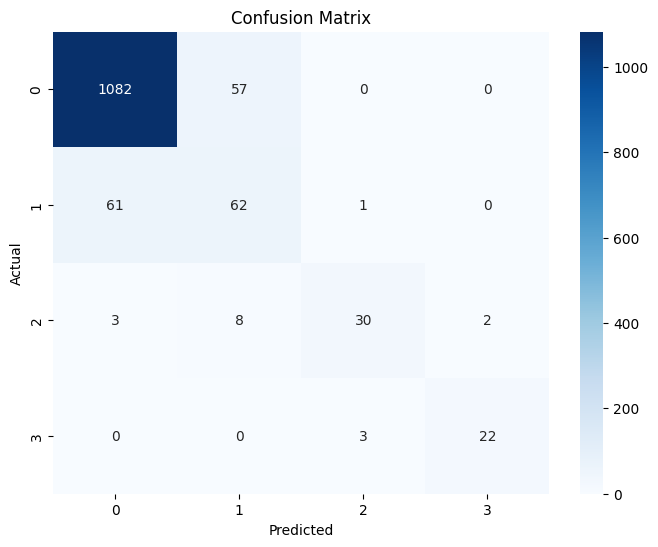

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1120
           1       0.60      0.49      0.54       147
           2       0.90      0.64      0.75        42
           3       0.78      0.86      0.82        21

    accuracy                           0.90      1330
   macro avg       0.80      0.74      0.76      1330
weighted avg       0.89      0.90      0.90      1330



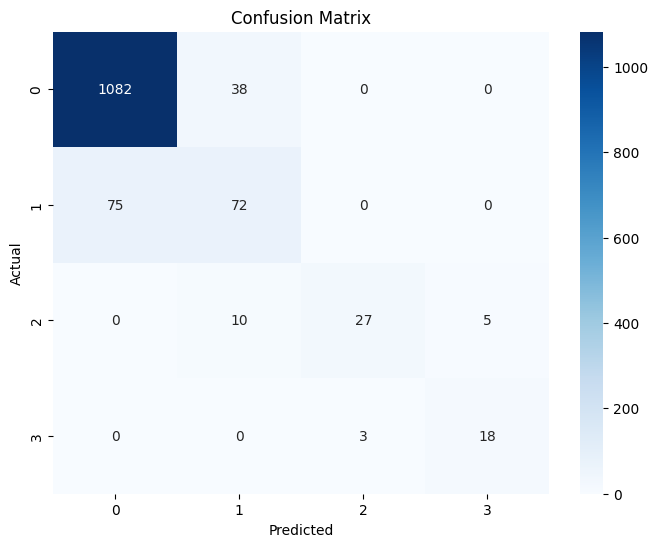

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1126
           1       0.61      0.58      0.59       148
           2       0.70      0.60      0.65        35
           3       0.84      0.76      0.80        21

    accuracy                           0.91      1330
   macro avg       0.77      0.73      0.75      1330
weighted avg       0.90      0.91      0.90      1330



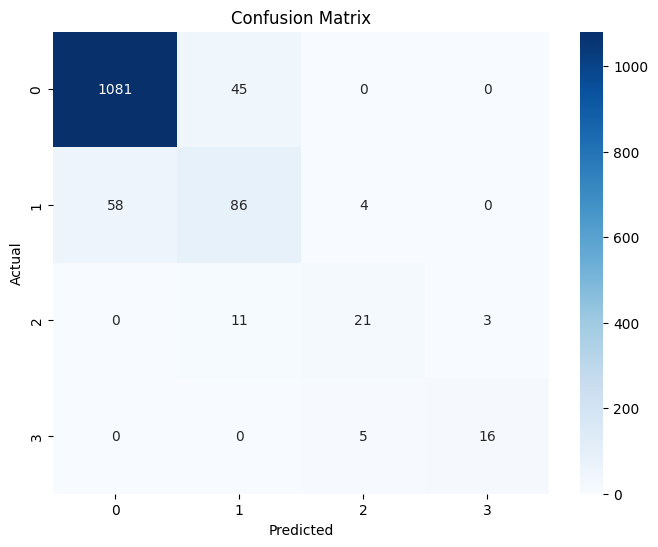

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1117
           1       0.57      0.53      0.55       144
           2       0.86      0.76      0.81        41
           3       0.96      0.82      0.88        28

    accuracy                           0.90      1330
   macro avg       0.83      0.77      0.80      1330
weighted avg       0.90      0.90      0.90      1330



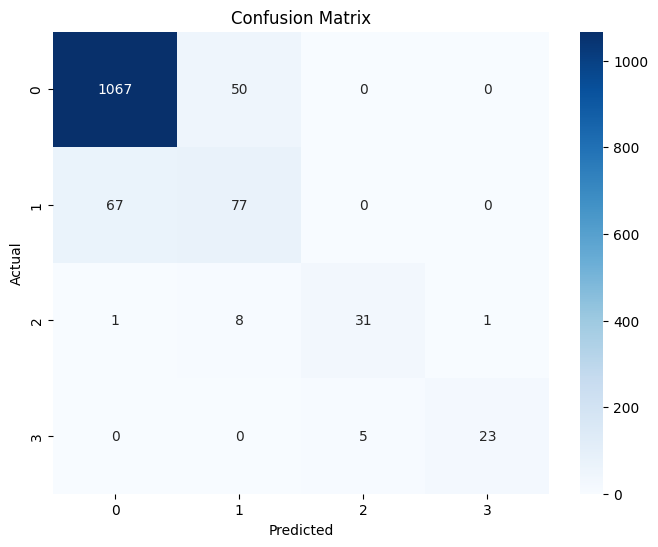

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1122
           1       0.56      0.53      0.54       141
           2       0.84      0.74      0.79        43
           3       0.90      0.75      0.82        24

    accuracy                           0.90      1330
   macro avg       0.81      0.75      0.77      1330
weighted avg       0.90      0.90      0.90      1330



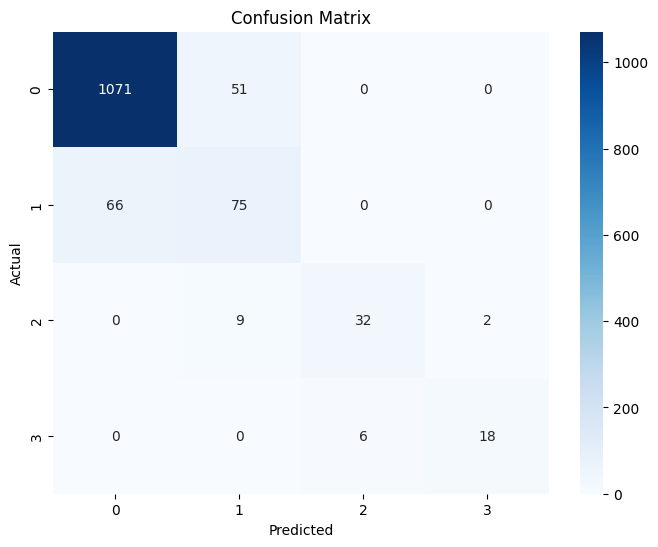

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1123
           1       0.57      0.54      0.55       145
           2       0.81      0.68      0.74        38
           3       0.88      0.88      0.88        24

    accuracy                           0.90      1330
   macro avg       0.80      0.76      0.78      1330
weighted avg       0.90      0.90      0.90      1330



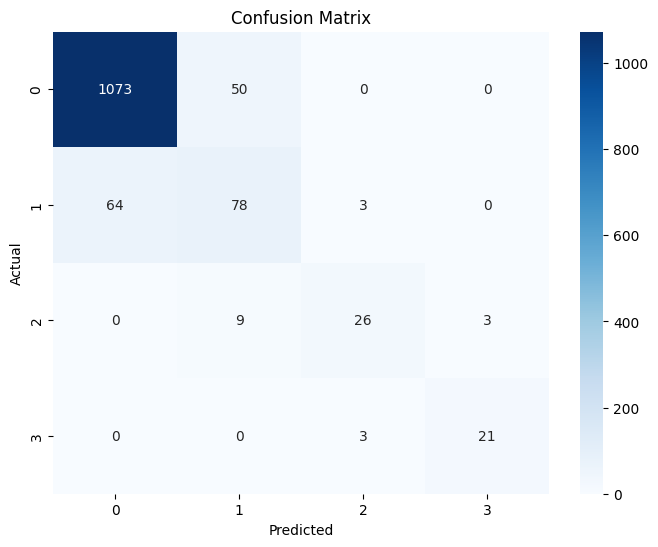

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1134
           1       0.55      0.49      0.52       137
           2       0.81      0.70      0.75        37
           3       0.84      0.76      0.80        21

    accuracy                           0.90      1329
   macro avg       0.79      0.73      0.75      1329
weighted avg       0.89      0.90      0.90      1329



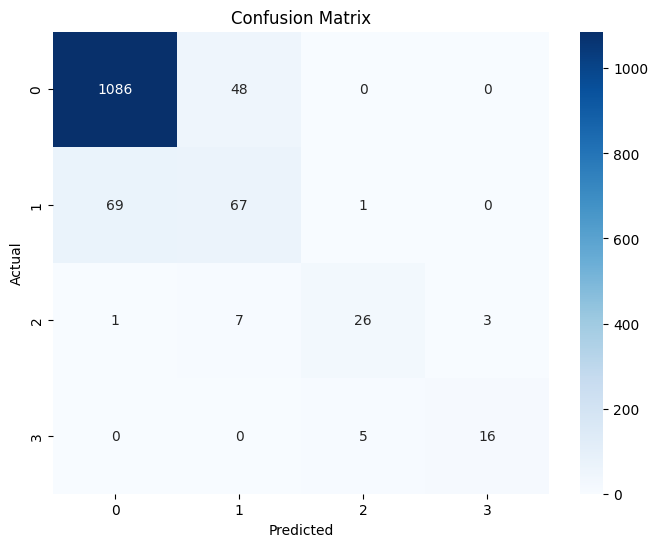

    Days  Precision    Recall  F1-Score  Support  Accuracy
2    2.0   0.399002  0.418093  0.407950      NaN  0.891872
3    3.0   0.367668  0.434284  0.392847      NaN  0.886652
4    4.0   0.362461  0.448613  0.390314      NaN  0.885160
5    5.0   0.328491  0.374786  0.346225      NaN  0.851493
6    6.0   0.346672  0.402750  0.366058      NaN  0.856716
7    7.0   0.380464  0.399802  0.368946      NaN  0.852985
8    8.0   0.504905  0.367993  0.364924      NaN  0.837313
9    9.0   0.546427  0.396201  0.411611      NaN  0.842537
10  10.0   0.490561  0.397677  0.402389      NaN  0.847647
11  11.0   0.493507  0.419796  0.434528      NaN  0.851382
12  12.0   0.466044  0.378923  0.392427      NaN  0.842420
13  13.0   0.504614  0.456607  0.470440      NaN  0.865571
14  14.0   0.436862  0.440939  0.437255      NaN  0.858103
15  15.0   0.478400  0.473087  0.472678      NaN  0.871450
16  16.0   0.467035  0.463276  0.464582      NaN  0.876682
17  17.0   0.475508  0.484127  0.479197      NaN  0.8609

In [810]:
import pandas as pd

# Define the range of values for num
num_range = range(2, 61)

# Initialize a DataFrame to store the results
res = pd.DataFrame(columns=['Days', 'Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy'])

best_num = None
best_f1_score = 0  # Initialize with a low value

for num in num_range:
    X, y = ProcessData(data, num)
    y = y.apply(CategorizeRainFall)

    precision, recall, f1_score, support, accuracy = ScoreSVM(X, y)
    
    # Store the results in the DataFrame
    res.loc[num] = [num, precision, recall, f1_score, support, accuracy]

    # Check if the current F1-score is better than the best so far
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_num = num

print(res)
print(f'Best number of days: {best_num}')
print(f'Best F1-score: {best_f1_score}')

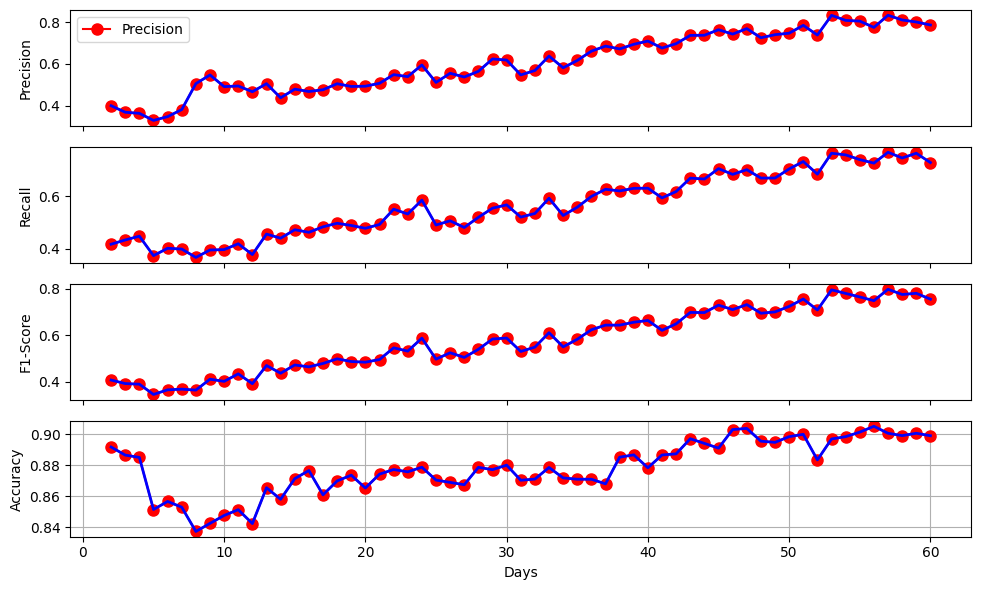

In [811]:
import matplotlib.pyplot as plt

# Giả sử res là DataFrame chứa các độ đo (precision, recall, f1-score, accuracy)
# Các cột trong res: 'Days', 'Precision', 'Recall', 'F1-Score', 'Accuracy'

# Choose colors and markers for the dots and lines
dot_color = 'red'
line_color = 'blue'
dot_marker = 'o'

# Tạo bảng biểu đồ
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 6), sharex=True)

# Đặt tên cho các đường trong biểu đồ
lines = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

# Lặp qua từng độ đo và vẽ biểu đồ tương ứng
for i, line in enumerate(lines):
    # Đường chấm
    axes[i].plot(res['Days'], res[line], marker=dot_marker, markersize=8, color=dot_color, label=line)
    
    # Đường thẳng nối các điểm
    axes[i].plot(res['Days'], res[line], linestyle='-', linewidth=2, color=line_color)
    
    # Đặt nhãn cho trục y cho biểu đồ hiện tại
    axes[i].set_ylabel(line)

# Đặt nhãn cho trục x (chung cho tất cả biểu đồ)
axes[-1].set_xlabel('Days')

# Hiển thị chú thích (legend)
axes[0].legend()

# Hiển thị biểu đồ
plt.grid(True)
plt.tight_layout()
plt.show()

In [812]:
# from keras.utils import to_categorical
# from sklearn.model_selection import train_test_split

# # Chuyển đổi nhãn thành mã hóa one-hot
# y_encoded = to_categorical(y, num_classes=4)

# # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# from keras.models import Sequential
# from keras.layers import LSTM, Dense

# model = Sequential()
# model.add(LSTM(50, input_shape=(num, 1)))
# model.add(Dense(4, activation='softmax'))  # Lớp đầu ra với activation 'softmax' cho phân loại thành 4 lớp
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=50, batch_size=32)

# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)

# from sklearn.metrics import classification_report
# print(classification_report(y_true, y_pred_classes))